In [1]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tools import add_constant
from matplotlib import pyplot

In [2]:
def logistic_map(x):
    return np.exp(x)/(1+np.exp(x))

def logistic_inv(x):
    return np.log(x/(1-x))

def print_population_log_odds(P_T,P_C):
    pop_log_odds = logistic_inv(P_T)-logistic_inv(P_C)
    print("P O P U L A T I O N")
    print("------------------------------------------")
    print("Population log odds = {:.2f}".format(pop_log_odds))
    print("Population odds ratio = {:.2f}\n\n".format(np.exp(pop_log_odds)))
    return pop_log_odds

def logistic_vs_plugin(sampler,pop_log_odds,ntrials=1000,nsamples=10000):
    '''
    Run ntrials experiments where we sample n individuals from the population, fit a 
    logistic model predicting Y from (X,Z), and then using the coefficient of X as an 
    estimate of the log odds. Display the average point estimate and the frequency in 
    which the true log odds falls in the 95% confidence interval. Also compute a 
    plug-in estimate of the log odds for comparison.

    sampler: method that produces n samples from the generative model of (X,Z,Y)
    pop_log_odds: true population log odds
    ntrials : number of times to run the experiment
    nsamples:  number of samples from the population per experiment
    '''

    success_count=np.zeros(ntrials)
    beta_est = np.empty(ntrials)
    logistic_odds_ratio_est = np.empty(ntrials)
    plug_in_log_odds_est= np.empty(ntrials)
    for i in range(ntrials):

        # sample nsamples from the distribution
        covariate,treatment,outcome = sampler(nsamples)

        # run logistic regression and compute confidence intervals
        features = add_constant(np.hstack((treatment[:,None],covariate[:,None])))
        model = sm.Logit(outcome, features).fit(disp=0)

        beta_est[i] = model.params[1]
        logistic_odds_ratio_est[i] = np.exp(model.params[1])
        lower_int = model.conf_int(alpha=0.05, cols=None)[1,0]   
        if lower_int<pop_log_odds:
            success_count[i]=1

        # plugin estimator
        P_T_est = np.sum(treatment*outcome)/np.sum(treatment)
        P_C_est = np.sum((1-treatment)*outcome)/np.sum(1-treatment)  
        plug_in_log_odds_est[i]= np.log(P_T_est/(1-P_T_est))-np.log(P_C_est/(1-P_C_est))


    print("L O G I S T I C   R E G R E S S I O N")
    print("------------------------------------------")
    print("Median estimate of treatment coefficient = {:.2f}".format(np.median(beta_est)))
    print("Median estimated odds ratio from logistic = {:.2f}".format(np.median(logistic_odds_ratio_est)))
    print("Confidence interval contains population log-odds {:.0f}% of the time\n\n".format(100*np.mean(success_count)))

    print("P L U G I N   E S T I M A T O R")
    print("------------------------------------------")
    print("Median plugin estimate of log odds = {:.2f}".format(np.median(plug_in_log_odds_est)))
    print("Median estimated odds ratio from plugin = {:.2f}\n\n".format(np.median(np.exp(plug_in_log_odds_est))))

    # plot a histogram of the estimates
    bins = np.linspace(0, 1.1*np.amax(beta_est), 50)

    pyplot.hist(beta_est, bins, alpha=0.5, label='logistic estimate')
    pyplot.hist(plug_in_log_odds_est, bins, alpha=0.5, label='plugin estimate')
    pyplot.plot([pop_log_odds,pop_log_odds],[0,100],color=[0,0,0])
    pyplot.legend(loc='upper right')
    pyplot.show()

# Example 1: An additive model

True model is

$$
\mathbb{E}[Y|X,Z] = \delta_p X + p_{\mathrm{hi}}Z+(1-Z)p_{\mathrm{lo}}
$$

$X$ is the treatment variable, $Z$ the covariate. Both $X$ and $Z$ are independent Bernoulli variables with probability of $1$ equal to $\tfrac{1}{2}$.

In [3]:
p_hi = 0.8 # probability of success in the high probability subpopulation
p_lo = 0.2 # probability of success in the low probability subpopulation
delta_p = 0.05 # effect size

# probability of success under treatment
P_T_additive = delta_p + 0.5*p_hi+0.5*p_lo
# probability of success under control
P_C_additive = 0.5*p_hi+0.5*p_lo

def sample_additive_model(n):
    # generate covariate and treatment variables and compute conditional outcome probabilities
    covariate = np.random.binomial(1,0.5,n)
    treatment = np.random.binomial(1,0.5,n)
    prob = delta_p*treatment + (p_hi-p_lo)*covariate + p_lo
    outcome = np.random.binomial(1, prob)
    return covariate,treatment,outcome

P O P U L A T I O N
------------------------------------------
Population log odds = 0.20
Population odds ratio = 1.22


L O G I S T I C   R E G R E S S I O N
------------------------------------------
Median estimate of treatment coefficient = 0.32
Median estimated odds ratio from logistic = 1.37
Confidence interval contains population log-odds 38% of the time


P L U G I N   E S T I M A T O R
------------------------------------------
Median plugin estimate of log odds = 0.20
Median estimated odds ratio from plugin = 1.22




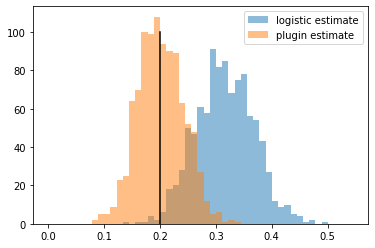

In [4]:
pop_log_odds_additive=print_population_log_odds(P_T_additive,P_C_additive)
logistic_vs_plugin(sample_additive_model,pop_log_odds_additive)

# Example 2: An actual logistic model

True model is

$$
\log \frac {\mathbb{P}[Y=1|X,Z]}{1-\mathbb{P}[Y=1|X,Z]} = \alpha + \beta X + \gamma Z
$$

$X$ is the treatment variable, $Z$ the covariate. Both $X$ and $Z$ are independent Bernoulli variables with probability of $1$ equal to $\tfrac{1}{2}$.

In [5]:
# logistic model parameters
alpha_true = -1.5 
beta_true =  0.4 
gamma_true =  3.0

# probability of success under treatment
p_hi_T = logistic_map(alpha_true+beta_true+gamma_true)
p_lo_T = logistic_map(alpha_true+beta_true)
P_T_logistic = 0.5*p_hi_T+0.5*p_lo_T

# probability of success under control
p_hi_C = logistic_map(alpha_true+gamma_true)
p_lo_C = logistic_map(alpha_true)
P_C_logistic = 0.5*p_hi_C+0.5*p_lo_C

def sample_logistic_model(n):
    # generate covariate and treatment variables and compute conditional outcome probabilities
    covariate = np.random.binomial(1,0.5,n)
    treatment = np.random.binomial(1,0.5,n)
    prob = logistic_map(alpha_true + beta_true*treatment + gamma_true*covariate)
    outcome = np.random.binomial(1, prob)
    return covariate,treatment,outcome


P O P U L A T I O N
------------------------------------------
Population log odds = 0.24
Population odds ratio = 1.27


L O G I S T I C   R E G R E S S I O N
------------------------------------------
Median estimate of treatment coefficient = 0.40
Median estimated odds ratio from logistic = 1.49
Confidence interval contains population log-odds 13% of the time


P L U G I N   E S T I M A T O R
------------------------------------------
Median plugin estimate of log odds = 0.24
Median estimated odds ratio from plugin = 1.27




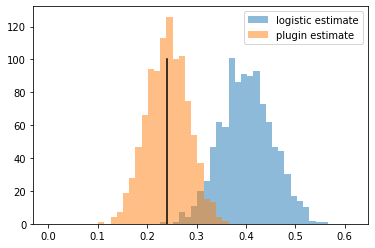

In [6]:
pop_log_odds_logistic=print_population_log_odds(P_T_logistic,P_C_logistic)
logistic_vs_plugin(sample_logistic_model,pop_log_odds_logistic)